In [6]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

  Using cached scipy-1.7.3-cp39-cp39-macosx_10_9_x86_64.whl (33.2 MB)


In [134]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cpu



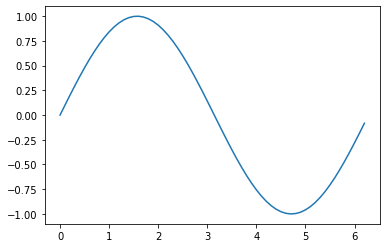

In [25]:
time_interval = np.arange(0,2*np.pi,0.1)
sin_wave = np.sin(time_interval)
plt.plot(time_interval, sin_wave)

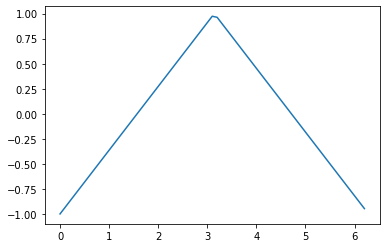

In [26]:
triangle_wave = signal.sawtooth(time_interval, 0.5)
plt.plot(time_interval, triangle_wave)

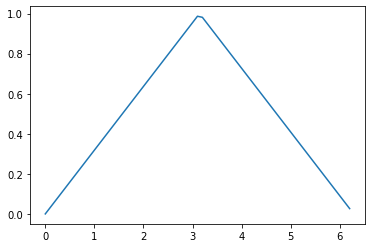

In [27]:
saw_wave = (signal.sawtooth(time_interval, 0.5)+1)/2
plt.plot(time_interval, saw_wave)

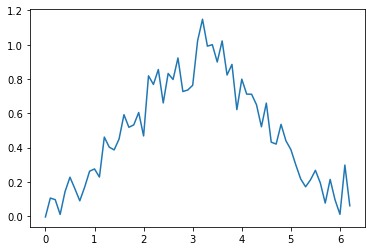

In [43]:
# adding noise to the datas
noise = np.random.normal(0,0.1,len(time_interval),)
plt.plot(time_interval, saw_wave+noise)

#### Making Datas

In [104]:
class WavesDataset(Dataset):
    def __init__(self, num_datas):
        
        self.num_datas = num_datas
        self.noisy_datas = []
        self.real_datas = []
        num_datas_train = 10
        for i in range(self.num_datas):
            
            noise = np.random.normal(0,0.1,len(time_interval))
            data0 = saw_wave+noise
            data1 = triangle_wave+noise
            data2 = sin_wave+noise

            self.noisy_datas.append(data0)
            self.real_datas.append(saw_wave)
            self.noisy_datas.append(data1)
            self.real_datas.append(triangle_wave)
            self.noisy_datas.append(data2)
            self.real_datas.append(sin_wave)
        

    def __len__(self):
        return self.num_datas

    def __getitem__(self, index):
        noisy = self.noisy_datas[index]
        real = self.real_datas[index]

        return torch.tensor(noisy), torch.tensor(real)

In [108]:
def get_loader(num_datas=1000, batch_size=32, shuffle=True, pin_memory=True, num_workers=0):
  
    dataset_train = WavesDataset(num_datas)
    dataset_test =  WavesDataset(int(num_datas/10))

    train_loader = DataLoader(
        dataset=dataset_train,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory
    )

    test_loader = DataLoader(
        dataset=dataset_test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory
    )

    return train_loader, test_loader

#### Network

In [188]:
class DenoiserRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DenoiserRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

#### Training

In [196]:
def validation():
  
  Loss = 0
  with torch.no_grad():
    for idx, (noisy_data, main_data) in enumerate(test_loader):
        input2net = noisy_data.unsqueeze(2).float() 
        expected_out = main_data.unsqueeze(2).float()
        outputs = Net(input2net)
        loss = criterion(outputs, expected_out)
        Loss = Loss+loss.item()
  Loss = Loss/(idx+1)
  return Loss

In [209]:
def train(print_every):
    num_itters = len(train_loader)
    for epoch in range(num_epochs):
        step = 0
        for idx, (noisy_data, main_data) in enumerate(train_loader):
            input2net = noisy_data.unsqueeze(2).float() 
            expected_out = main_data.unsqueeze(2).float()
            outputs = Net(input2net)
            loss = criterion(outputs, expected_out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step % print_every == 0:
              loss_val = validation()
              stats = '{2}/{3} - {0}/{1} |  Loss train - val = {4:.4f} - {5:.4f}'.format(
                    idx, num_itters, epoch, num_epochs, loss.item(), loss_val)
              print('\r' + stats)
            step+=1

In [211]:
num_epochs = 5
input_dim = 1
hidden_size = 30
num_layers = 1
lr = 3e-4

Net = DenoiserRNN(input_dim, hidden_size, 1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(Net.parameters(),lr=lr)

train_loader, test_loader = get_loader(50000)
train(500)

0/5 - 0/1563 |  Loss train-val = 0.4063 - 0.3776
0/5 - 500/1563 |  Loss train-val = 0.0118 - 0.0129
0/5 - 1000/1563 |  Loss train-val = 0.0095 - 0.0104
0/5 - 1500/1563 |  Loss train-val = 0.0088 - 0.0093
1/5 - 0/1563 |  Loss train-val = 0.0091 - 0.0092
1/5 - 500/1563 |  Loss train-val = 0.0081 - 0.0079
1/5 - 1000/1563 |  Loss train-val = 0.0062 - 0.0064
1/5 - 1500/1563 |  Loss train-val = 0.0058 - 0.0057
2/5 - 0/1563 |  Loss train-val = 0.0052 - 0.0057
2/5 - 500/1563 |  Loss train-val = 0.0045 - 0.0048
2/5 - 1000/1563 |  Loss train-val = 0.0042 - 0.0042
2/5 - 1500/1563 |  Loss train-val = 0.0034 - 0.0038
3/5 - 0/1563 |  Loss train-val = 0.0036 - 0.0037
3/5 - 500/1563 |  Loss train-val = 0.0035 - 0.0037
3/5 - 1000/1563 |  Loss train-val = 0.0035 - 0.0033
3/5 - 1500/1563 |  Loss train-val = 0.0032 - 0.0031
4/5 - 0/1563 |  Loss train-val = 0.0030 - 0.0032
4/5 - 500/1563 |  Loss train-val = 0.0028 - 0.0030
4/5 - 1000/1563 |  Loss train-val = 0.0028 - 0.0029
4/5 - 1500/1563 |  Loss train-va

torch.Size([32, 63, 1])


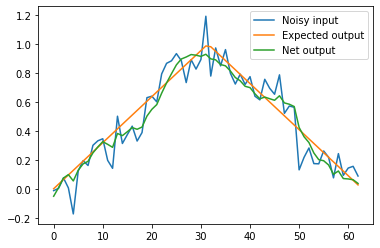

torch.Size([32, 63, 1])


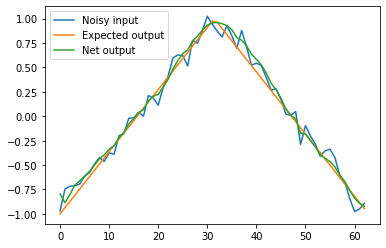

torch.Size([32, 63, 1])


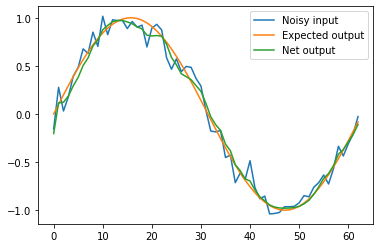

torch.Size([32, 63, 1])


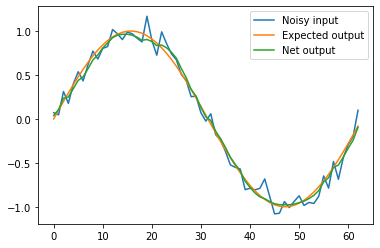

torch.Size([32, 63, 1])


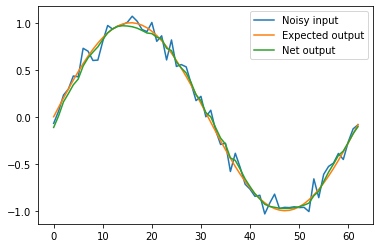

torch.Size([32, 63, 1])


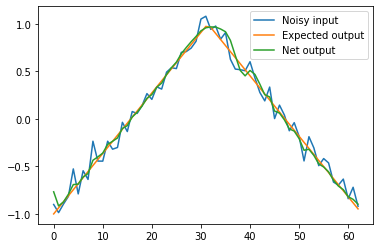

In [212]:
for idx, (noisy_data, main_data) in enumerate(test_loader):
    input2net = noisy_data.unsqueeze(2).float() 
    expected_out = main_data.unsqueeze(2).float()
    with torch.no_grad():
        output = Net(input2net)
    print(output.shape)
    plt.plot(input2net[0,:,0].numpy(),label='Noisy input')
    plt.plot(expected_out[0,:,0].numpy(),label='Expected output')
    plt.plot(output[0,:,0].numpy(),label='Net output')
    plt.legend()
    plt.show()
    if idx>4:
        break
